### Imports

In [1]:
# Imports e configurações iniciais
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import LeaveOneOut, GridSearchCV, cross_val_predict, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
import warnings
warnings.filterwarnings("ignore")

### DATAFRAME

In [2]:
df = pd.read_csv('dados-fonte.csv', sep=';')

df['media_veg_rip'] = (df['veg_rip_D'] + df['veg_rip_E'])/2

#Transformações
df["log_Turbidez"] = np.log(df["Turbidez"] + 1)

# Escalonamento
scaler = StandardScaler()
scaled_vars = scaler.fit_transform(df[["OD", "Temp", "pH", "Condutividade", "Turbidez", "log_Turbidez", "media_veg_rip"]])
scaled_df = pd.DataFrame(scaled_vars, columns=["OD_scaled", "Temp_scaled","pH_scaled", "Cond_scaled", "Turb_scaled", "logTurb_scaled", "media_veg_rip_scaled"])

# Atribuição ao DataFrame principal
df["OD_scaled"] = scaled_df["OD_scaled"]
df["Temp_scaled"] = scaled_df["Temp_scaled"]
df["pH_scaled"] = scaled_df["pH_scaled"]
df["Cond_scaled"] = scaled_df["Cond_scaled"]
df["Turb_scaled"] = scaled_df["Turb_scaled"]
df["logTurb_scaled"] = scaled_df["logTurb_scaled"]
df["media_veg_rip_scaled"] = scaled_df["media_veg_rip_scaled"]
df['OD/Temp'] = scaled_df["OD_scaled"] / scaled_df["Temp_scaled"]
df['Turb/OD'] = scaled_df["Turb_scaled"] / scaled_df["OD_scaled"]
df["ph_quad"] = (scaled_df["pH_scaled"] - scaled_df["pH_scaled"].mean())**2
df['Temp_quad'] = (scaled_df['Temp_scaled'] - scaled_df['Temp_scaled'].mean())**2


# Calcula EPT_proxy 
df["EPT_proxy"] = df["OD_scaled"] + 0.5*df["pH_scaled"] - df["logTurb_scaled"] - df["Cond_scaled"] + df["media_veg_rip_scaled"]

df

,Riacho/sitio,OD,Temp,pH,Condutividade,Turbidez,veg_rip_D,veg_rip_E,PAH_I,PAH_II,...,pH_scaled,Cond_scaled,Turb_scaled,logTurb_scaled,media_veg_rip_scaled,OD/Temp,Turb/OD,ph_quad,Temp_quad,EPT_proxy
0,1,10.00,16.1,6.90,39.8,1.20,6,8,NaN,81,...,0.386162,-0.418140,-0.601837,-1.036882,0.151478,-1.893972,-0.430357,0.149121,0.545196,3.198041
1,2,8.70,15.8,7.20,36.4,5.30,9,9,NaN,78,...,1.441213,-0.488926,-0.446328,-0.207758,0.887226,-0.548224,-0.977735,2.077096,0.693346,2.761009
2,3,8.90,15.8,7.10,38.2,2.70,6,8,NaN,79,...,1.089530,-0.451451,-0.544944,-0.627183,0.151478,-0.722264,-0.906110,1.187075,0.693346,2.376287
3,4,9.30,15.8,6.90,42.7,1.42,9,9,NaN,52,...,0.386162,-0.357765,-0.593493,-0.961771,0.887226,-1.070343,-0.665913,0.149121,0.693346,3.291089
4,5,8.60,16.5,6.50,35.2,10.90,6,6,NaN,49,...,-1.020572,-0.513909,-0.233926,0.293446,-0.216396,-0.626849,-0.609129,1.041568,0.375329,-0.122187
5,6,9.00,16.0,7.10,32.2,3.00,7,9,NaN,83,...,1.089530,-0.576367,-0.533565,-0.565744,0.519352,-0.875374,-0.791793,1.187075,0.592603,2.880096
6,7,7.80,17.2,6.50,36.2,4.10,9,6,NaN,109,...,-1.020572,-0.493090,-0.491843,-0.374285,0.335415,0.498308,2.514028,1.041568,0.154141,0.496864
7,8,8.40,17.3,6.60,32.0,2.40,8,8,NaN,94,...,-0.668889,-0.580530,-0.556322,-0.693820,0.519352,-0.662048,-2.326590,0.447412,0.130447,1.698373
8,9,9.80,15.6,7.20,39.1,3.30,10,10,NaN,128,...,1.441213,-0.432714,-0.522186,-0.508750,1.255100,-1.399760,-0.416569,2.077096,0.801993,4.170712
9,10,9.10,16.4,6.60,40.0,2.37,9,9,NaN,128,...,-0.668889,-0.413976,-0.557460,-0.700805,0.887226,-1.158762,-0.746937,0.447412,0.414832,2.413891


### Analise Exploratória de Dados

In [3]:
#Imprime as estatísticas básicas
print(df.describe().T.round(2))

                      count   mean    std    min    25%    50%     75%     max
Riacho/sitio           51.0  26.00  14.87   1.00  13.50  26.00   38.50   51.00
OD                     51.0   8.07   1.39   4.44   7.18   8.40    9.15   10.30
Temp                   51.0  18.45   3.21  13.20  15.80  17.20   20.70   26.60
pH                     51.0   6.79   0.29   6.08   6.60   6.80    7.00    7.30
Condutividade          51.0  59.88  48.51  25.30  35.70  42.00   60.00  280.70
Turbidez               51.0  17.07  26.63   0.00   2.34   5.30   22.90  143.30
veg_rip_D              51.0   6.80   3.13   0.00   4.00   8.00    9.00   10.00
veg_rip_E              51.0   6.37   3.27   0.00   3.50   7.00    9.00   10.00
PAH_I                  23.0  15.87   3.27   8.00  15.00  16.00   18.00   20.00
PAH_II                 51.0  93.82  23.44  35.00  78.50  93.00  113.50  132.00
Riqueza_EPT             8.0   7.62   5.29   2.00   3.00   7.00   12.25   14.00
media_veg_rip          51.0   6.59   2.75   1.00   4

### CORRELAÇÃO ENTRE AS VARIÁVEIS

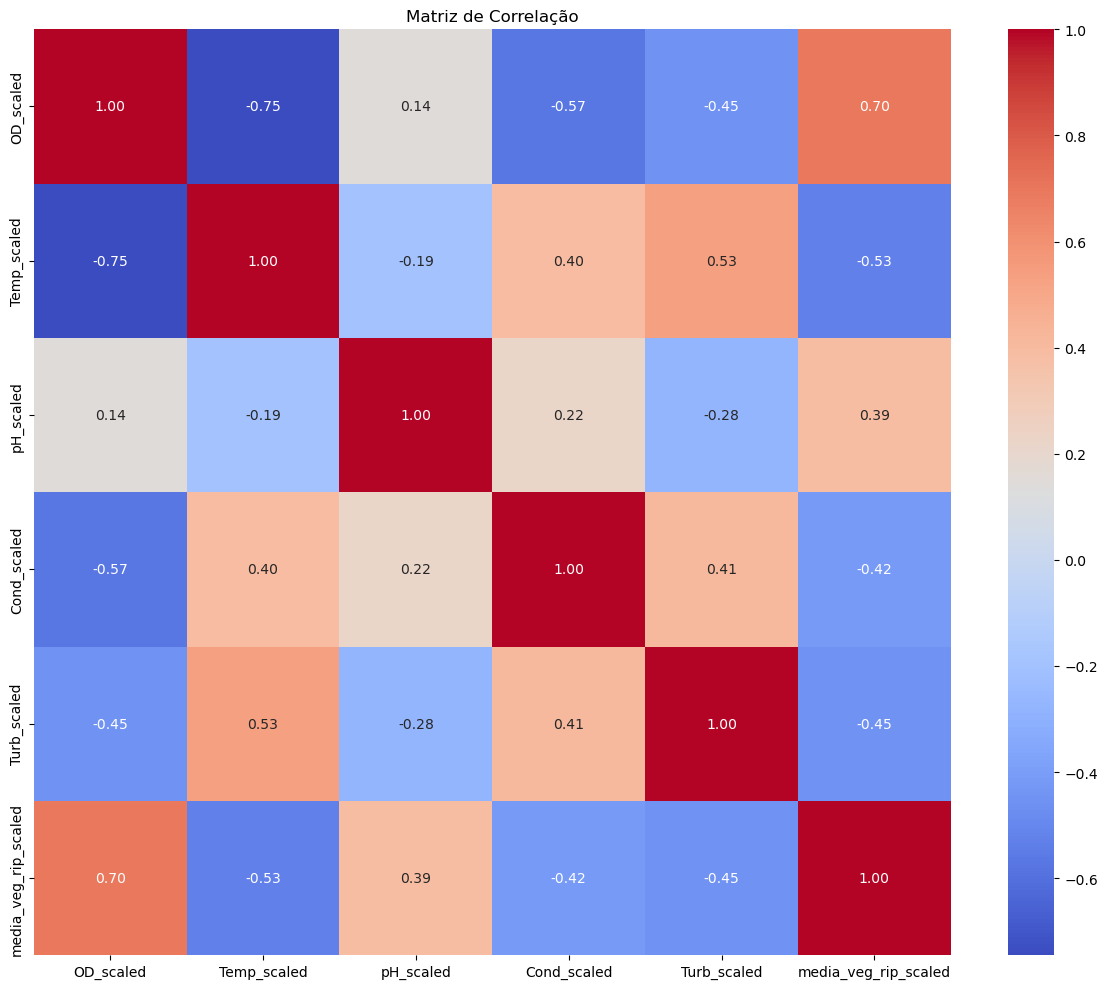

In [4]:
# Seleciona as colunas das variáveis abióticas para analisar a correlação entre elas
colunas_desejadas = [
    'OD_scaled', 'Temp_scaled', 'pH_scaled',
    'Cond_scaled', 'Turb_scaled', 'media_veg_rip_scaled'
]

df_continuas = df[colunas_desejadas]
matriz_corr = df_continuas.corr()

# Gera a matriz de correlação
plt.figure(figsize=(12, 10))
sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação')
plt.tight_layout()

plt.savefig('matriz_correlacao.png', dpi=300, bbox_inches='tight')
plt.show()


Turbidez:
Assimetria: 2.8895198660186296

log_Turbidez:
Assimetria: 0.22193462195344557


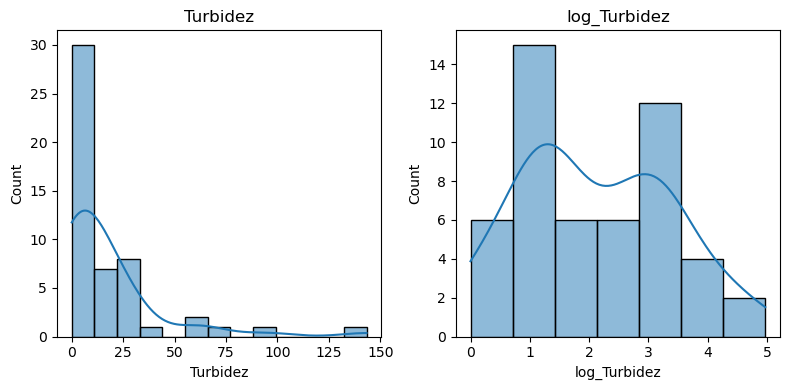

In [5]:
turb = df['Turbidez'].dropna()
log_turb = df['log_Turbidez'].dropna()

print("Turbidez:")
print("Assimetria:", stats.skew(turb))

print("\nlog_Turbidez:")
print("Assimetria:", stats.skew(log_turb))

# Gera os 2 gráficos lado a lado
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

sns.histplot(turb, kde=True, ax=axes[0])
axes[0].set_title('Turbidez')

sns.histplot(log_turb, kde=True, ax=axes[1])
axes[1].set_title('log_Turbidez')

plt.tight_layout()
plt.savefig('graficos_lado_a_lado_turb.png')
plt.show()

### CLASSIFICAÇÂO PAH

In [6]:
# Função de classificação para PAH_II
def classificar_pah(score):
    if score > 110: # Boa
        return 2
    elif score > 85: # Média
        return 1
    else: # Ruim
        return 0

df["classe_qualidade"] = df["PAH_II"].apply(classificar_pah)

### NORMALIZAÇÃO EPT PROXY

In [7]:
# Normalizando a EPT_proxy
df["EPT_proxy_norm"] = (
    df["EPT_proxy"] - df["EPT_proxy"].min()
) / (
    df["EPT_proxy"].max() - df["EPT_proxy"].min()
)

# Função para classificar os valores normalizados
def classificar_ept(valor):
    if valor >= 0.66:
        return "Alta riqueza EPT"
    elif valor >= 0.33:
        return "Riqueza intermediária"
    else:
        return "Baixa riqueza EPT"

# Aplicando a função
df["EPT_proxy_classe"] = df["EPT_proxy_norm"].apply(classificar_ept)
df["EPT_proxy_classe"].value_counts()

EPT_proxy_classe
Alta riqueza EPT         27
Riqueza intermediária    17
Baixa riqueza EPT         7
Name: count, dtype: int64

### DISTRIBUIÇÃO EPT_PROXY

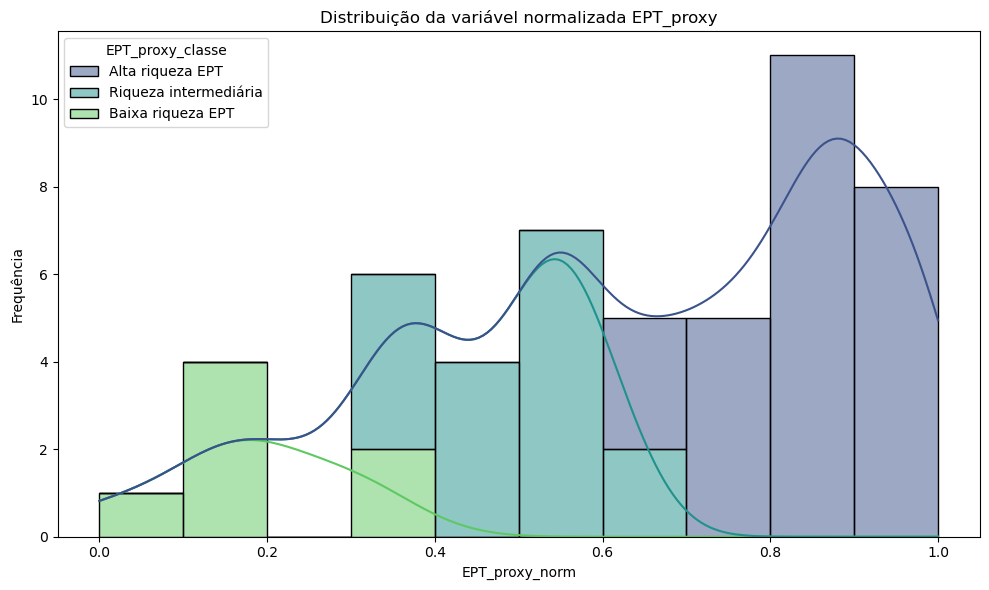

In [8]:
# Definição do tamanho da figura
plt.figure(figsize=(10, 6))

# Histograma com curvas de densidade e classes coloridas
sns.histplot(
    data=df,
    x="EPT_proxy_norm",
    bins=10,
    kde=True,
    hue="EPT_proxy_classe",  # categorização visual
    palette="viridis",
    multiple="stack"  # empilha as faixas
)

plt.title("Distribuição da variável normalizada EPT_proxy")
plt.xlabel("EPT_proxy_norm")
plt.ylabel("Frequência")
#plt.grid(True)
plt.tight_layout()

plt.savefig('distr_EPTproxy.png')
plt.show()

### CORRELAÇÃO E SIGNIFICÂNCIA ESTATÍSTICA


 Correlação entre EPT_proxy_norm e PAH I:
 - Coeficiente r  = 0.63 (forte)
 - Coeficiente r² = 0.39 (39.2% da variação explicada)
 - p-valor = 0.00139565 ⇒ significativa


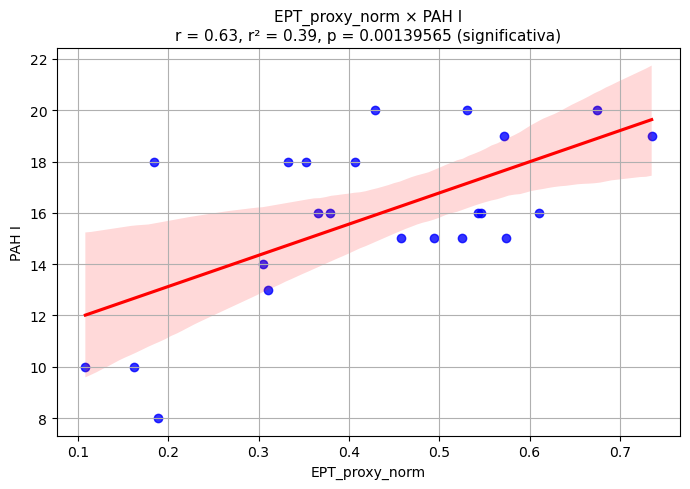


 Correlação entre EPT_proxy_norm e PAH II:
 - Coeficiente r  = 0.60 (forte)
 - Coeficiente r² = 0.36 (36.4% da variação explicada)
 - p-valor = 0.00000274 ⇒ significativa


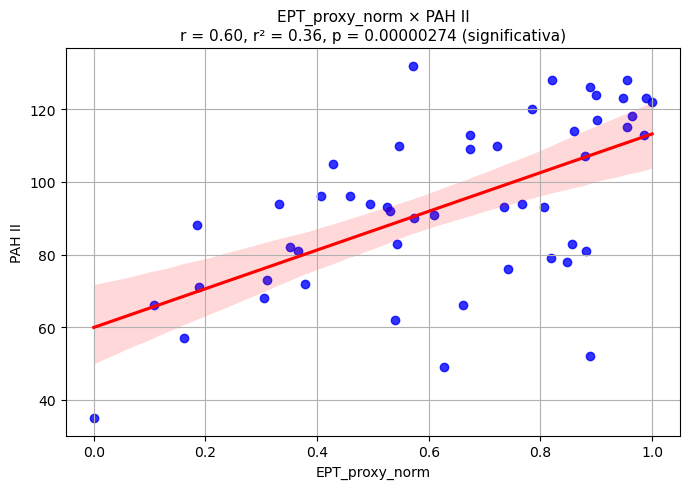

In [9]:
# Função para interpretação qualitativa do coeficiente
def interpretar_correlacao(r):
    abs_r = abs(r)
    if abs_r < 0.2:
        return "muito fraca"
    elif abs_r < 0.4:
        return "fraca"
    elif abs_r < 0.6:
        return "moderada"
    elif abs_r < 0.8:
        return "forte"
    else:
        return "muito forte"

# Função para teste de correlação com gráfico
def testar_correlacao_com_grafico(x, y, nome_x, nome_y):
    r, p = pearsonr(x, y)
    r2 = r**2
    interpretacao = interpretar_correlacao(r)
    significancia = "significativa" if p < 0.05 else "não significativa"

    # Print no console
    print(f"\n Correlação entre {nome_x} e {nome_y}:")
    print(f" - Coeficiente r  = {r:.2f} ({interpretacao})")
    print(f" - Coeficiente r² = {r2:.2f} ({r2*100:.1f}% da variação explicada)")
    print(f" - p-valor = {p:.8f} ⇒ {significancia}")

    # Gráfico
    plt.figure(figsize=(7, 5))
    sns.regplot(x=x, y=y, ci=95, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
    plt.xlabel(nome_x)
    plt.ylabel(nome_y)
    plt.title(
        f"{nome_x} × {nome_y}\n"
        f"r = {r:.2f}, r² = {r2:.2f}, p = {p:.8f} ({significancia})",
        fontsize=11
    )
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('teste.png')
    plt.show()


# Cria uma cópia limpa do DataFrame, removendo linhas onde EPT ou PAH sejam NaN
df_cleaned = df.dropna(subset=['EPT_proxy_norm', 'PAH_I'])

# Aplicando a função para as variáveis desejadas
testar_correlacao_com_grafico(df_cleaned["EPT_proxy_norm"], df_cleaned["PAH_I"], "EPT_proxy_norm", "PAH I")

testar_correlacao_com_grafico(df["EPT_proxy_norm"], df["PAH_II"], "EPT_proxy_norm", "PAH II")


Correlação entre Riqueza real de famílias EPT e EPT_proxy (Spearman):
 - Coeficiente ρ  = 0.76 (forte)
 - ρ² = 0.57 (57.2% da variação monotônica)
 - p-valor = 0.02988438 ⇒ significativa


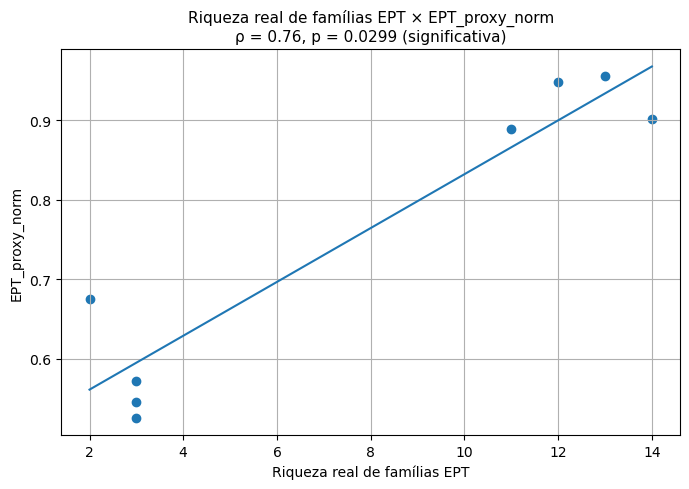

In [10]:
# Função para teste de correlação de Spearman com gráfico
def testar_correlacao_com_grafico(x, y, nome_x, nome_y):
    # Remove NaN
    mask = (~np.isnan(x)) & (~np.isnan(y))
    x = x[mask]
    y = y[mask]

    # Correlação de Spearman
    rho, p = spearmanr(x, y)
    rho2 = rho**2
    interpretacao = interpretar_correlacao(rho)
    significancia = "significativa" if p < 0.05 else "não significativa"

    # Print no console
    print(f"\nCorrelação entre {nome_x} e {nome_y} (Spearman):")
    print(f" - Coeficiente ρ  = {rho:.2f} ({interpretacao})")
    print(f" - ρ² = {rho2:.2f} ({rho2*100:.1f}% da variação monotônica)")
    print(f" - p-valor = {p:.8f} ⇒ {significancia}")

    # Gráfico 
    plt.figure(figsize=(7,5))
    plt.scatter(x, y)
    coef = np.polyfit(x, y, 1)
    poly = np.poly1d(coef)
    x_line = np.linspace(x.min(), x.max(), 100)
    plt.plot(x_line, poly(x_line))

    plt.xlabel("Riqueza real de famílias EPT")
    plt.ylabel("EPT_proxy_norm")
    plt.title(
        f"Riqueza real de famílias EPT × EPT_proxy_norm\n"
        f"ρ = {rho:.2f}, p = {p:.4f} (significativa)",
        fontsize=11
    )

    plt.grid(True)
    plt.tight_layout()
    plt.savefig("EPT_proxy_norm_vs_RiquezaEPT.png", dpi=300, bbox_inches="tight")
    plt.show()


testar_correlacao_com_grafico(
    df["Riqueza_EPT"].values,
    df["EPT_proxy_norm"].values,
    "Riqueza real de famílias EPT",
    "EPT_proxy"
)

### SELEÇÂO DE VARIAVEIS E VALIDAÇÂO CRUZADA

In [11]:
# Seleção de variáveis mais importantes
X_full = df[['OD_scaled', 'pH_scaled', 'Cond_scaled', 'Turb_scaled', 'EPT_proxy', 'media_veg_rip_scaled', 'OD/Temp', 'Turb/OD', 'Temp_quad', 'ph_quad']]

y = df["classe_qualidade"]

rf_tmp = RandomForestClassifier(n_estimators=100, random_state=42)
rf_tmp.fit(X_full, y)
importancias_df = pd.Series(rf_tmp.feature_importances_, index=X_full.columns)
variaveis_reduzidas = importancias_df.sort_values(ascending=False).head(4).index.tolist()

X = df[variaveis_reduzidas]

# Validação cruzada repetida estratificada
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# Validação cruzada para avaliação dos modelos
cv_eval = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print(variaveis_reduzidas)

['EPT_proxy', 'media_veg_rip_scaled', 'OD_scaled', 'Cond_scaled']


# Modelos

## ARVORE DE DECISÃO

In [12]:
# Árvore de Decisão
dt_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('dt', DecisionTreeClassifier(class_weight='balanced', random_state=42))
])
dt_param_grid = {
    'dt__max_depth': [3, 5, None],
    'dt__min_samples_split': [2, 4, 6],
    'dt__criterion': ['gini', 'entropy']
}
dt_grid = GridSearchCV(dt_pipeline, dt_param_grid, cv=cv, scoring='f1_macro', n_jobs=-1)
dt_grid.fit(X, y)

print("Melhores parâmetros encontrados:")
print(dt_grid.best_params_)

Melhores parâmetros encontrados:
{'dt__criterion': 'entropy', 'dt__max_depth': 5, 'dt__min_samples_split': 4}


## RANDOM FOREST

In [13]:
# RandomForest
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42))
])
rf_param_grid = {
    'rf__n_estimators': [50, 100],
    'rf__max_depth': [3, 5, None],
    'rf__max_features': ['sqrt', 'log2']
}
rf_grid = GridSearchCV(rf_pipeline, rf_param_grid, cv=cv, scoring='f1_macro', n_jobs=-1)
rf_grid.fit(X, y)

print("Melhores parâmetros encontrados:")
print(rf_grid.best_params_)

Melhores parâmetros encontrados:
{'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__n_estimators': 100}


## KNN

In [14]:
# KNN
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('knn', KNeighborsClassifier())
])

# Grade de parâmetros
knn_param_grid = {
    'knn__n_neighbors': list(range(3, 20)), 
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]
}

knn_grid = GridSearchCV(knn_pipeline, knn_param_grid, cv=cv, scoring='f1_macro', n_jobs=-1)
knn_grid.fit(X, y)

print("Melhores parâmetros encontrados:")
print(knn_grid.best_params_)


Melhores parâmetros encontrados:
{'knn__n_neighbors': 6, 'knn__p': 1, 'knn__weights': 'distance'}


## SVM

In [15]:
pesos_candidatos = [{0: 1.0, 1: 1.0, 2: 0.8}, {0: 1.0, 1: 1.0, 2: 0.7}, "balanced"]

param_grid_svm = [
    # Dicionário de parâmetros para o kernel RBF (não-linear)
    {
        'svm__kernel': ['rbf'],
        'svm__C': [0.1, 1, 10],           
        'svm__gamma': ['scale', 0.01, 0.1], 
        'svm__class_weight': pesos_candidatos
    },
    # Dicionário de parâmetros para o kernel Linear 
    {
        'svm__kernel': ['linear'],
        'svm__C': [0.1, 1, 10],          
        'svm__class_weight': pesos_candidatos
        # O kernel linear não utiliza o parâmetro gamma
    }
]


# Construindo e treinando o GridSearchCV
svm_grid = GridSearchCV(
    Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('svm', SVC(probability=True))
    ]),
    param_grid=param_grid_svm, 
    cv=cv,                    
    scoring='f1_macro',
    n_jobs=-1,
    refit=True
)

svm_grid.fit(X, y)

print("Melhores parâmetros encontrados:")
print(svm_grid.best_params_)

Melhores parâmetros encontrados:
{'svm__C': 10, 'svm__class_weight': {0: 1.0, 1: 1.0, 2: 0.7}, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}


## REGRESSÃO LOGISTICA

In [16]:
# Regressão Logística
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(class_weight='balanced', max_iter=1000))
])
lr_param_grid = {
    'lr__C': [0.01, 0.1, 1, 10],
    'lr__penalty': ['l2'],
    'lr__solver': ['lbfgs']
}
lr_grid = GridSearchCV(lr_pipeline, lr_param_grid, cv=cv, scoring='f1_macro', n_jobs=-1)
lr_grid.fit(X, y)

print("Melhores parâmetros encontrados:")
print(lr_grid.best_params_)

Melhores parâmetros encontrados:
{'lr__C': 10, 'lr__penalty': 'l2', 'lr__solver': 'lbfgs'}


# RESULTADOS

## Desempenho dos modelos


Avaliação: Árvore de Decisão
F1-macro (Treino): 0.878
F1-macro (CV): 0.620 ± 0.155
MCC (CV): 0.482 ± 0.222
Gap (Overfitting): 0.259
Indício de overfitting: desempenho muito melhor no treino do que na validação.

Relatório de classificação (validação):
              precision    recall  f1-score   support

        Ruim       0.69      0.58      0.63        19
       Média       0.65      0.65      0.65        17
         Boa       0.56      0.67      0.61        15

    accuracy                           0.63        51
   macro avg       0.63      0.63      0.63        51
weighted avg       0.64      0.63      0.63        51



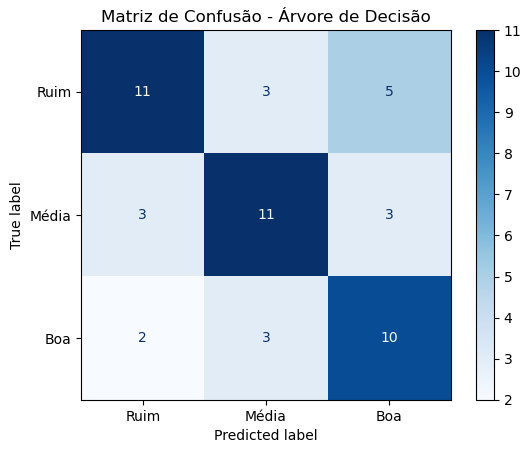


Avaliação: RandomForest 
F1-macro (Treino): 1.000
F1-macro (CV): 0.672 ± 0.157
MCC (CV): 0.549 ± 0.189
Gap (Overfitting): 0.328
Indício de overfitting: desempenho muito melhor no treino do que na validação.

Relatório de classificação (validação):
              precision    recall  f1-score   support

        Ruim       0.73      0.58      0.65        19
       Média       0.60      0.71      0.65        17
         Boa       0.69      0.73      0.71        15

    accuracy                           0.67        51
   macro avg       0.67      0.67      0.67        51
weighted avg       0.68      0.67      0.67        51



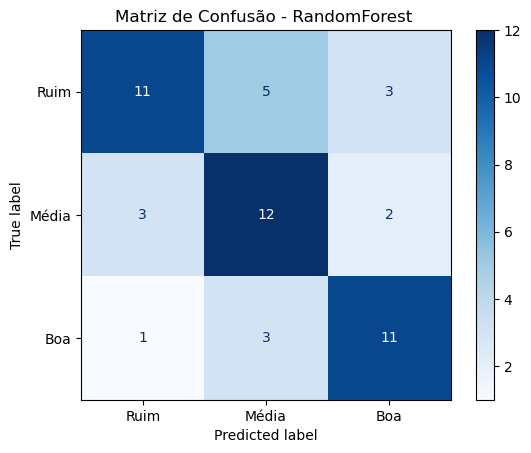


Avaliação: SVM
F1-macro (Treino): 0.803
F1-macro (CV): 0.796 ± 0.150
MCC (CV): 0.674 ± 0.173
Gap (Overfitting): 0.007

Relatório de classificação (validação):
              precision    recall  f1-score   support

        Ruim       0.88      0.74      0.80        19
       Média       0.75      0.88      0.81        17
         Boa       0.80      0.80      0.80        15

    accuracy                           0.80        51
   macro avg       0.81      0.81      0.80        51
weighted avg       0.81      0.80      0.80        51



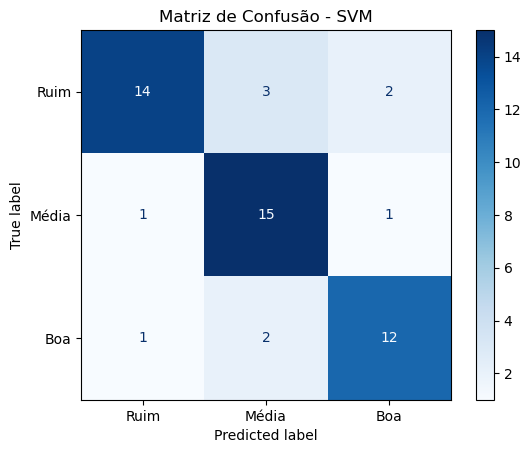


Avaliação: KNN
F1-macro (Treino): 1.000
F1-macro (CV): 0.710 ± 0.197
MCC (CV): 0.597 ± 0.207
Gap (Overfitting): 0.290
Indício de overfitting: desempenho muito melhor no treino do que na validação.

Relatório de classificação (validação):
              precision    recall  f1-score   support

        Ruim       0.76      0.68      0.72        19
       Média       0.71      0.71      0.71        17
         Boa       0.65      0.73      0.69        15

    accuracy                           0.71        51
   macro avg       0.71      0.71      0.71        51
weighted avg       0.71      0.71      0.71        51



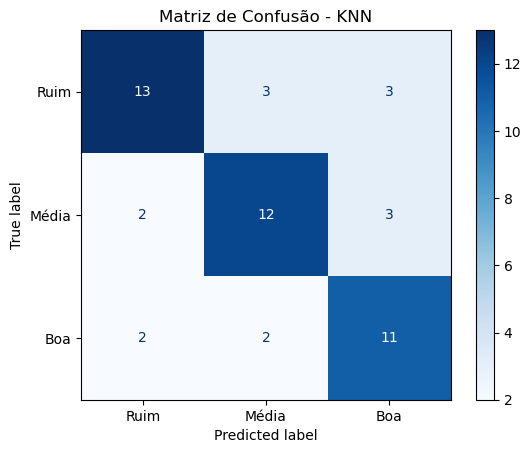


Avaliação: Regressão Logística
F1-macro (Treino): 0.725
F1-macro (CV): 0.706 ± 0.199
MCC (CV): 0.572 ± 0.227
Gap (Overfitting): 0.019

Relatório de classificação (validação):
              precision    recall  f1-score   support

        Ruim       0.75      0.63      0.69        19
       Média       0.69      0.65      0.67        17
         Boa       0.68      0.87      0.76        15

    accuracy                           0.71        51
   macro avg       0.71      0.72      0.71        51
weighted avg       0.71      0.71      0.70        51



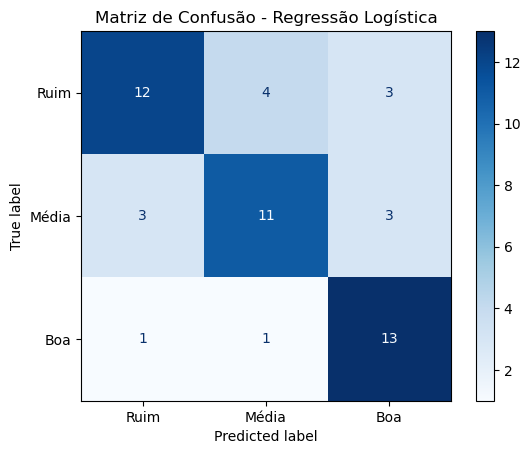

In [17]:
resultados = []

def avaliar_modelo(melhor_modelo, nome):
    # F1-macro
    f1_scores = cross_val_score(
        melhor_modelo, X, y,
        cv=cv_eval,
        scoring=make_scorer(f1_score, average="macro")
    )
    f1_cv_mean = np.mean(f1_scores)
    f1_cv_std = np.std(f1_scores)

    # MCC  
    mcc_scorer = make_scorer(matthews_corrcoef)
    mcc_scores = cross_val_score(melhor_modelo, X, y, cv=cv, scoring=mcc_scorer)
    mcc_cv_mean = np.mean(mcc_scores)
    mcc_cv_std = np.std(mcc_scores)

    # Previsões no treino inteiro 
    y_pred_train = melhor_modelo.fit(X, y).predict(X)
    f1_train = f1_score(y, y_pred_train, average="macro")

    gap = f1_train - f1_cv_mean

    print(f"\nAvaliação: {nome}")
    print(f"F1-macro (Treino): {f1_train:.3f}")
    print(f"F1-macro (CV): {f1_cv_mean:.3f} ± {f1_cv_std:.3f}")
    print(f"MCC (CV): {mcc_cv_mean:.3f} ± {mcc_cv_std:.3f}")
    print(f"Gap (Overfitting): {gap:.3f}")

    if gap > 0.15:
        print("Indício de overfitting: desempenho muito melhor no treino do que na validação.")

    # Relatório e matriz de confusão
    y_pred_cv = cross_val_predict(melhor_modelo, X, y, cv=cv_eval)

    print("\nRelatório de classificação (validação):")
    print(classification_report(
        y, y_pred_cv, labels=[0, 1, 2],
        target_names=["Ruim", "Média", "Boa"],
        zero_division=0
    ))

    # Matriz de confusão
    cm = confusion_matrix(y, y_pred_cv, labels=[0, 1, 2])
    disp = ConfusionMatrixDisplay(cm, display_labels=["Ruim", "Média", "Boa"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Matriz de Confusão - {nome}")
    plt.grid(False)
    plt.savefig('matriz_confusão.png', dpi=300, bbox_inches='tight')
    plt.show()


# Chamadas para os modelos
avaliar_modelo(dt_grid.best_estimator_, "Árvore de Decisão")
avaliar_modelo(rf_grid.best_estimator_, "RandomForest ")
avaliar_modelo(svm_grid.best_estimator_, "SVM")
avaliar_modelo(knn_grid.best_estimator_, "KNN")
avaliar_modelo(lr_grid.best_estimator_, "Regressão Logística")

## Importância das variáveis

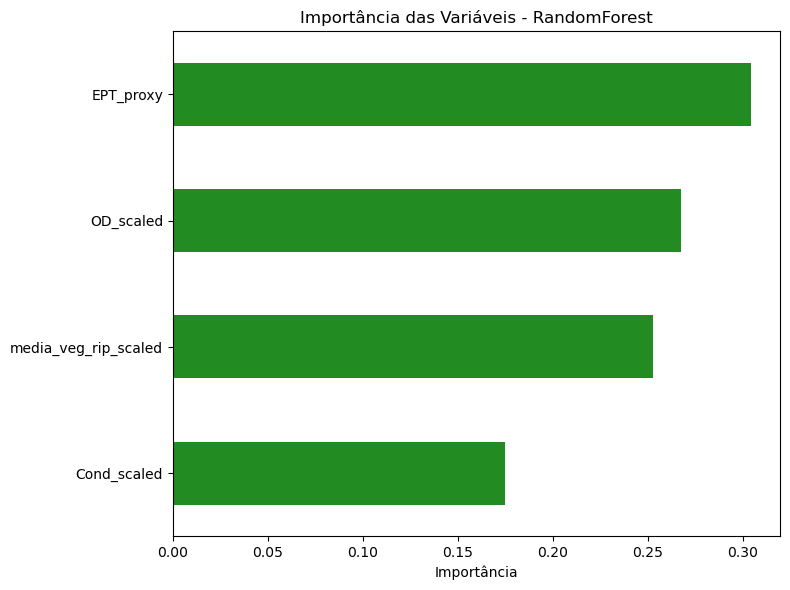

In [18]:
# Importância das Variáveis - RandomForest
rf_final = rf_grid.best_estimator_.named_steps['rf']
importancias = rf_final.feature_importances_
importancias_df = pd.Series(importancias, index=X.columns).sort_values(ascending=True)
importancias_df.plot(kind='barh', figsize=(8, 6), color='forestgreen')
plt.title("Importância das Variáveis - RandomForest")
plt.xlabel("Importância")
plt.tight_layout()
plt.savefig('importancias.png', dpi=300, bbox_inches='tight')
plt.show()